In [1]:
"""
vessels
"""
import warnings
warnings.filterwarnings('ignore')

import glob
import shutil
import pickle
import os
import time
import pandas
from pandas import concat
import numpy
import matplotlib.pyplot as plt
import random
import pyproj

In [2]:
#######################################################################################################################

def trajectories_to_supervised_fast_df(data, N_TIMESTEPS, TIMESTEPS_AS_FORECAST_SEQUENCE):
    #Make inputs & outputs 
    n_in = N_TIMESTEPS
    n_out = TIMESTEPS_AS_FORECAST_SEQUENCE
    df0 = data.copy()
    df0['id2'] = df0['id'].copy()
    agg = pandas.DataFrame()
    print(df0)
    for iii in range(n_in, 0, -1):
        df0_shifted__1 = df0.groupby(['id2']).shift(iii).copy()
        df0_shifted__1.rename(columns=lambda x: ('%s(t-%d)' % (x, iii)), inplace=True)
        agg = pandas.concat([agg, df0_shifted__1], axis=1)

    for iii in range(0, n_out):
        df0_shifted_1 = df0.groupby(['id2']).shift(-iii).copy()
        if iii == 0:
            df0_shifted_1.rename(columns=lambda x: ('%s(t)' % (x)), inplace=True)
        else:
            df0_shifted_1.rename(columns=lambda x: ('%s(t+%d)' % (x, iii)), inplace=True)
        agg = pandas.concat([agg, df0_shifted_1], axis=1)
    agg.dropna(inplace=True)
    df0 = agg.copy()
    return df0
    df0
    

In [3]:
########################################################################################################################
#def trajectories_to_supervised(data, N_TIMESTEPS, TIMESTEPS_AS_FORECAST_SEQUENCE):
#    n_in = N_TIMESTEPS
#    n_out = TIMESTEPS_AS_FORECAST_SEQUENCE
#    """
#   Frame a time series as a supervised learning dataset.
#   Arguments:
#      data: Sequence of observations as a list or NumPy array.
#      n_in: Number of lag observations as input (X).
#      n_out: Number of observations as output (y).
#      dropnan: Boolean whether or not to drop rows with NaN values.
#   Returns:
#      Pandas DataFrame of series framed for supervised learning.
#   """
#    if n_in == 1 and n_out == 1:
#        agg = pandas.concat([data.shift(1).rename(columns=lambda x: ('%s(t-1)' % (x))),
#                             data.rename(columns=lambda x: ('%s(t)' % (x)))], axis=1)
#    else:
#        n_vars = data.shape[1]
#        df = data.copy()
#        cols, names = list(), list()
#        for i in range(n_in, 0, -1):
#            cols.append(df.shift(i))
#            names += [('%s(t-%d)' % (df.head(0).columns[j], i)) for j in range(n_vars)]
#        for i in range(0, n_out):
#            cols.append(df.shift(-i))  # cols.append(df.loc[:, FEATURES_PREDICT].shift(-i))
#            if i == 0:
#                names += [('%s(t)' % (df.head(0).columns[j])) for j in range(n_vars)]
#            else:
#                names += [('%s(t+%d)' % (df.head(0).columns[j], i)) for j in range(n_vars)]#
#
#        agg = concat(cols, axis=1)
#        #agg.columns = 
#    """    
#    # drop rows with NaN values
#    # if dropnan==True:
#"""
#    agg.dropna(inplace=True)
#    return agg

In [4]:
########################################################################################################################
def statistics_per_ship2(df):
    df.id.unique().shape
    gb = df.groupby('id')['id'].transform('size')
    dff = df.copy()
    dff['num_records'] = gb
    dff = dff.groupby(['id', 'num_records']).size().reset_index(name='Freq')
    print('Number of points per id')
    print(dff.Freq.describe())
    plt.hist(dff.Freq, 208)
    plt.title('Histogram - Number of records per ship')
    plt.xlabel('Number of records')
    plt.ylabel('Number of ships')
    plt.show()

    df_id_t_min = df.groupby('id')['t'].min().reset_index()
    df_id_t_max = df.groupby('id')['t'].max().reset_index()
    df_id_t_min['id'].equals(df_id_t_max['id'])
    df_id_t0 = df_id_t_max.t - df_id_t_min.t
    df_id_tt = pandas.DataFrame(
        {'id': df_id_t_min['id'].values, 't_min': df_id_t_min['t'].values, 't_max': df_id_t_max['t'].values})
    df_id_tt['t_diff'] = df_id_tt['t_max'] - df_id_tt['t_min']
    df_id_tt = df_id_tt.groupby(['id', 't_diff']).size().reset_index(name='Freq')
    print('Total Duration per id')
    print(df_id_tt.t_diff.describe())

In [5]:
########################################################################################################################
def fun_delete_ids_with_limited_points(df, VAL_DEL_N_MIN_TMSTPS):
    """ Delete rows with less than del_n_tmstps points """
    gb = df.groupby('id')['id'].transform('size')  #Calculate the number of points per id
    df.drop(df[gb < VAL_DEL_N_MIN_TMSTPS].index, inplace=True) # Drop ids
    df.reset_index(drop=True, inplace=True)  #Reset indexes
    return df
    print(df)

In [6]:
########################################################################################################################
def fun_calculate_dt_dlon_dlat_dist_speed_accel(df):
    """Calculate speed of movement(in meters/sec) from one location to another"""
    df['dt'] = (df['t'].groupby(df['id']).diff()).values  # Diff Time in seconds
    df['dlon'] = (df['lon'].groupby(df['id']).diff()).values  # Diff Longitude in meters
    df['dlat'] = (df['lat'].groupby(df['id']).diff()).values  # Diff Latitude in meters
    df['dist_m'] = numpy.sqrt(df.dlon.values ** 2 + df.dlat.values ** 2)  # euclidean distance in meters
    df['speed'] = df['dist_m'] / df['dt']
    df['dspeed'] = (df['speed'].groupby(df['id']).diff()).values
    return df
    print(df)

In [7]:
########################################################################################################################
def split_trajectories(df, VAL_DEL_N_MIN_TMSTPS, VAL_GAP_PERIOD, VAL_MAX_TRAJ_DURATION, VAL_MAX_TRAJ_POINTS):
    # # Split trajectories

    # Split trajectories if dt > VAL_GAP_PERIOD
    start = time.time()
    gb = df['dt'].groupby(df['id'])
    gb = [(gb.get_group(y) > VAL_GAP_PERIOD).apply(lambda x: 1 if x else 0).cumsum() for y in gb.groups]
    # Add id for split into df
    gbdf = pandas.concat(gb)
    df['id_dt'] = gbdf.sort_index()
    # Make new ids based on id & id_dt
    # df['id'] = df['id_dt'] + df['id'] + df['id'].max()
    # Make new ids based on id & id_dt
    df['id'] = df.groupby(['id', 'id_dt']).ngroup()
    df.drop(columns=['id_dt'], inplace=True)
    print('..............\n', 'After "split trajectories if dt > VAL_GAP_PERIOD"', VAL_GAP_PERIOD,
          'Number of points :', df.shape[0], '  &  ', 'Number of mmsi:', df.mmsi.unique().shape[0], '  &  ',
          'Number of id:', df.id.unique().shape[0])

    df = fun_delete_ids_with_limited_points(df, VAL_DEL_N_MIN_TMSTPS)  # delete mmsi with less than del_n_tmstps points
    df = fun_calculate_dt_dlon_dlat_dist_speed_accel(df)
    df.reset_index(drop=True, inplace=True)
    df['id'] = df.groupby(['id']).ngroup() + 1  # Number each group
    print('SPLIT: After dropping ids with less than ', VAL_DEL_N_MIN_TMSTPS, 'Number of points :', df.shape[0],
          '  &  ', 'Number of mmsi:', df.mmsi.unique().shape[0], '  &  ', 'Number of id:', df.id.unique().shape[0],
          '\n..............')
    print(time.time() - start)

    # # # Split trajectories if traj_duration > VAL_MAX_TRAJ_DURATION
    start = time.time()
    # df['cumsum'] = df.groupby('id')['dt'].transform(pandas.Series.cumsum)
    # df['dt_traj_all'] = df['t'].groupby(df['id']).transform(lambda x: max(x)-min(x))
    df['dt_traj'] = (df['dt'].groupby(df['id']).cumsum()).values
    # gb = df['dt_traj'].groupby(df['id'])
    # gb = [(gb.get_group(y).max()) for y in gb.groups]
    df_ok = pandas.DataFrame()
    while df['dt_traj'].max() > VAL_MAX_TRAJ_DURATION:
        df_ok = pandas.concat([df_ok, df[numpy.isnan(df['dt_traj'])], df[df['dt_traj'] <= VAL_MAX_TRAJ_DURATION]],
                              sort=False)
        df_ok.drop(df_ok[df_ok.groupby('id')['id'].transform('size') < VAL_DEL_N_MIN_TMSTPS].index,
                   inplace=True)  # delete id with less than n points
        df = df[df['dt_traj'] > VAL_MAX_TRAJ_DURATION].copy()
        df.drop(df[df.groupby('id')['id'].transform('size') < VAL_DEL_N_MIN_TMSTPS].index,
                inplace=True)  # delete id with less than n points
        df['id'] = df.groupby(['id']).ngroup() + 1 + max(df_ok['id'].max(), df['id'].max())  # Make new ids
        df['dt'] = (df['t'].groupby(df['id']).diff()).values
        df['dt_traj'] = (df['dt'].groupby(df['id']).cumsum()).values
    df = pandas.concat([df_ok, df], sort=False)
    # df.dropna(inplace=True)
    df.drop(columns=['dt_traj'], inplace=True)
    df.sort_values(by=['id', 't'], ascending=[True, True], inplace=True)
    print('..............\n', 'After "split trajectories if traj_duration > VAL_MAX_TRAJ_DURATION"',
          VAL_MAX_TRAJ_DURATION, 'Number of points :', df.shape[0], '  &  ', 'Number of mmsi:',
          df.mmsi.unique().shape[0], '  &  ', 'Number of id:', df.id.unique().shape[0])

    df = fun_delete_ids_with_limited_points(df, VAL_DEL_N_MIN_TMSTPS)  # delete mmsi with less than del_n_tmstps points
    df = fun_calculate_dt_dlon_dlat_dist_speed_accel(df)
    df.reset_index(drop=True, inplace=True)
    df['id'] = df.groupby(['id']).ngroup() + 1  # Number each group
    print('SPLIT: After dropping ids with less than ', VAL_DEL_N_MIN_TMSTPS, 'Number of points :', df.shape[0],
          '  &  ', 'Number of mmsi:', df.mmsi.unique().shape[0], '  &  ', 'Number of id:', df.id.unique().shape[0],
          '\n..............')
    print(time.time() - start)

    # Split trajectories if num_points > VAL_MAX_TRAJ_POINTS
    start = time.time()
    df['num'] = pandas.DataFrame(numpy.ones((df.shape[0], 1)))
    df['dt_traj'] = (df['num'].groupby(df['id']).cumsum()).values
    df_ok = pandas.DataFrame()
    while df['dt_traj'].max() > VAL_MAX_TRAJ_POINTS:
        df_ok = pandas.concat([df_ok, df[numpy.isnan(df['dt_traj'])], df[df['dt_traj'] <= VAL_MAX_TRAJ_POINTS]],
                              sort=False)
        df = df[df['dt_traj'] > VAL_MAX_TRAJ_POINTS].copy()
        df.drop(df[df.groupby('id')['id'].transform('size') < VAL_DEL_N_MIN_TMSTPS].index,
                inplace=True)  # delete id with less than n points
        df['id'] = df.groupby(['id']).ngroup() + 1 + max(df_ok['id'].max(), df['id'].max())  # Make new ids
        df['dt_traj'] = (df['num'].groupby(df['id']).cumsum()).values
    df = pandas.concat([df_ok, df], sort=False)
    df.drop(columns=['dt_traj'], inplace=True)
    df.sort_values(by=['id', 't'], ascending=[True, True], inplace=True)
    print('..............\n', 'After "split trajectories if traj_num_points > VAL_MAX_TRAJ_POINTS"',
          VAL_MAX_TRAJ_POINTS, 'Number of points :', df.shape[0], '  &  ', 'Number of mmsi:',
          df.mmsi.unique().shape[0], '  &  ', 'Number of id:', df.id.unique().shape[0])

    df = fun_delete_ids_with_limited_points(df, VAL_DEL_N_MIN_TMSTPS)  # delete mmsi with less than del_n_tmstps points
    df = fun_calculate_dt_dlon_dlat_dist_speed_accel(df)
    df.reset_index(drop=True, inplace=True)
    df['id'] = df.groupby(['id']).ngroup() + 1  # Number each group
    print('SPLIT: After dropping ids with less than ', VAL_DEL_N_MIN_TMSTPS, 'Number of points :', df.shape[0],
          '  &  ', 'Number of mmsi:', df.mmsi.unique().shape[0], '  &  ', 'Number of id:', df.id.unique().shape[0],
          '\n..............')
    print(time.time() - start)

    return df
    print(df)

In [8]:
#######################################################################################################################
def fun_shuffle(df, rand_seed):
    # df0 = df.copy()# Check augmentation TODO: delete
    groups = [df for _, df in df.groupby('id')]
    random.shuffle(groups, random.seed(rand_seed))
    pandas.concat(groups).reset_index(drop=True)
    df = pandas.concat(groups).reset_index(drop=True)
    df['id'] = df['id'].groupby(df['id'], sort=False).ngroup() + 1
    df.sort_values(by=['id', 't'], ascending=[True, True], inplace=True, ignore_index=True)
    # df00 = df.sort_values(by=['index'], ignore_index=True); df00.drop(columns = ['id'], inplace=True); df0.drop(columns = ['id'], inplace=True); print(df00.equals(df0)) # Check augmentation TODO: delete
    return df
    print(df)

In [9]:
def fun_shuffle_id(df, rand_seed):
    df_tr = fun_shuffle(df[df['dataset_tr1_val2_test3_augm_0'] == 1].copy(), rand_seed)
    df_tr['id'] = df_tr['id'].groupby(df_tr['id'], sort=False).ngroup() + 1

    df_va = fun_shuffle(df[df['dataset_tr1_val2_test3_augm_0'] == 2].copy(), rand_seed)
    df_va['id'] = df_va['id'].groupby(df_va['id'], sort=False).ngroup() + 1 + df_tr.id.max()

    df_te = fun_shuffle(df[df['dataset_tr1_val2_test3_augm_0'] == 3].copy(), rand_seed)
    df_te['id'] = df_te['id'].groupby(df_te['id'], sort=False).ngroup() + 1 + df_va.id.max()

    df = pandas.concat([df_tr, df_va, df_te], sort=False, ignore_index=True)
    df.sort_values(by=['id', 't'], ascending=[True, True], inplace=True, ignore_index=True)
    return df
    print(df)

In [10]:
#######################################################################################################################
def split_into_sets(df, VAL_DATA_SPLIT_TR, VAL_DATA_SPLIT_VA):
    ntr = int(df['id'].unique().shape[0] * VAL_DATA_SPLIT_TR)
    nva = int(df['id'].unique().shape[0] * VAL_DATA_SPLIT_VA)
    # nte = df['id'].unique().shape[0] - (ntr+nva)
    ids = df['id'].unique()
    ids_tr, ids_va, ids_te = ids[:ntr].copy(), ids[ntr:ntr + nva].copy(), ids[ntr + nva:].copy()
    df['dataset_tr1_val2_test3_augm_0'] = df['id'].copy()
    df.loc[df['id'].isin(ids_tr), 'dataset_tr1_val2_test3_augm_0'] = 1
    df.loc[df['id'].isin(ids_va), 'dataset_tr1_val2_test3_augm_0'] = 2
    df.loc[df['id'].isin(ids_te), 'dataset_tr1_val2_test3_augm_0'] = 3
    df['id_split'] = df['id'].copy()
    df['dataset_tr1_val2_test3_augm_0_norm'] = df['dataset_tr1_val2_test3_augm_0'].copy()
    return df, ntr, nva
    print(df)
    print(ntr)
    print(nva)

In [11]:
#######################################################################################################################
def clean_data(CSV_FILE_FOR_READ, VAL_DEL_N_MIN_TMSTPS, VAL_NO_SPEED_THRESHOLD, VAL_MAX_SPEED_THRESHOLD,
               VAL_GAP_PERIOD):
    # # 1. Read csv
    print("Start - Read ....")
    ###==============================================================================================================###

    df = pandas.read_csv(CSV_FILE_FOR_READ, delimiter=';', header=0, index_col=None)
    # convert to datetime
    df['t'] = (pandas.to_datetime(df['timestamp']).astype(numpy.int64) / 10 ** 9).astype(numpy.int64)
    print(max(df['t']))
    tmin = 1514764804
    tmax = 1546300764#tmin + (60 * 60 * 24 * 30 ) #########################TIME!!!!!!!!!!#####IT WAS = (60 * 60 * 24 * 30 * 4 )###
    df = df[(df['t'] > tmin) & (df['t'] < tmax)].copy()
    print(df['timestamp'].min(), df['timestamp'].max())
    print(df.shape[0])
    print('Number of points: %d, Number of vessels: %d' % (df.shape[0], df.mmsi.unique().shape[0]))
    df = df.drop(df[df.lon < 23.088642].index)
    df = df.drop(df[df.lon > 26.896934].index)
    df = df.drop(df[df.lat < 35.660669].index)
    df = df.drop(df[df.lat > 39.517331].index)

   
    print(df.shape[0])

    df.sort_values(by=['mmsi', 't'], ascending=[True, True], inplace=True)
    df['dt'] = (df['t'].groupby(df['mmsi']).diff()).values
    # df = df.drop(df[df.dt <= 60].index)  # delete all less than 60 sec because
    # df['dt'] = (df['t'].groupby(df['mmsi']).diff()).values

    print('Number of points: %d, Number of vessels: %d' % (df.shape[0], df.mmsi.unique().shape[0]))
    print('Number of points: %d, Number of vessels: %d' % (df.shape[0], df.mmsi.unique().shape[0]))

    # # 2. Initialize
    # df.rename(index=str, columns={"mmsi": "id"}, inplace=True)
    df['id'] = df['mmsi'].copy()
    df.sort_values(by=['id', 't'], ascending=[True, True], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['WGS84lon'] = df['lon'].values
    df['WGS84lat'] = df['lat'].values

    ###==============================================================================================================###
    print('..............\n', 'After dropping duplicates. ', 'Number of points:', df.shape[0], '  &  ',
          'Number of mmsi:', df.mmsi.unique().shape[0], '\n..............')
    # # -. Statistics
    # statistics_per_ship2(df)

    print("Start - Drop duplicate values ....")
    df.drop_duplicates(keep='first', inplace=True)
    df.drop_duplicates(subset=['id', 't'], inplace=True)  # Check if there are points with the same timestamp
    print('..............\n', 'After dropping duplicates. ', 'Number of points:', df.shape[0], '  &  ',
          'Number of mmsi:', df.mmsi.unique().shape[0], '\n..............')
    # # -. Statistics
    # statistics_per_ship2(df)

    print("Start - Convert lon & lat to UTM ....")
    # df.update(convert_lon_lat(df))
    df.reset_index(drop=True, inplace=True)
    myProj = pyproj.Proj("+proj=utm +zone=35N, +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    lon2, lat2 = myProj(df['WGS84lon'].values, df['WGS84lat'].values)
    df.update(pandas.DataFrame({'lon': lon2, 'lat': lat2}))

    print("Start - Calculate speed - Drop points with false speed ....")
    df = fun_calculate_dt_dlon_dlat_dist_speed_accel(df)
    df.reset_index(drop=True, inplace=True)
    df = df.drop(df[df.speed < VAL_NO_SPEED_THRESHOLD].index)  # Drop points with speed below val_NO_SPEED_THRESHOLD
    df = fun_calculate_dt_dlon_dlat_dist_speed_accel(df)
    df.reset_index(drop=True, inplace=True)
    print('Number of points after dropping records less than', VAL_NO_SPEED_THRESHOLD, ': ', df.shape[0])
    df = df.drop(df[df.speed > VAL_MAX_SPEED_THRESHOLD].index)  # Drop points with speed > .VAL_MAX_SPEED_THRESHOLD
    df = fun_calculate_dt_dlon_dlat_dist_speed_accel(df)
    df.reset_index(drop=True, inplace=True)
    # df = fun_delete_ids_with_limited_points(df, VAL_DEL_N_MIN_TMSTPS)  # delete mmsi with less than del_n_tmstps points
    print('Number of points after dropping records with speed outside [', VAL_NO_SPEED_THRESHOLD, ' ,',
          VAL_MAX_SPEED_THRESHOLD, ']: ', df.shape[0])
    # # -. Statistics
    # statistics_per_ship2(df)

    stop_iterations = 0
    delete_speed_min = 0
    n = 0
    while delete_speed_min == 0:
        old_len = df.shape[0]
        df = df.drop(df[(df.dt <= VAL_GAP_PERIOD) & (df.speed < VAL_NO_SPEED_THRESHOLD)].index)
        df = fun_calculate_dt_dlon_dlat_dist_speed_accel(df)
        df.reset_index(drop=True, inplace=True)
        new_len = df.shape[0]
        n = n + 1
        if old_len == new_len or stop_iterations == n:
            delete_speed_min = 1
    print('Number of points after dropping records with speed less than', VAL_NO_SPEED_THRESHOLD, ': ', df.shape[0],
          'and iterations: ', n)
    stop_iterations = 0
    delete_speed_max = 0
    n = 0
    while delete_speed_max == 0:
        old_len = df.shape[0]
        df = df.drop(df[(df.dt <= VAL_GAP_PERIOD) & (df.speed > VAL_MAX_SPEED_THRESHOLD)].index)
        df = fun_calculate_dt_dlon_dlat_dist_speed_accel(df)
        df.reset_index(drop=True, inplace=True)
        new_len = df.shape[0]
        n = n + 1
        if old_len == new_len or stop_iterations == n:
            delete_speed_max = 1
    print('Number of points after dropping records with speed outside [', VAL_NO_SPEED_THRESHOLD, ' ,',
          VAL_MAX_SPEED_THRESHOLD, ']: ', df.shape[0], 'and iterations: ', n)

    # if VAL_DATASET == 'ais_kinematic_aegean_2018nov_distinct_types':
    #     df = df.drop(df[df.dt <= 60].index)  # delete all less than 60 sec because
    #     df.reset_index(drop=True, inplace=True)  # Reset indexes
    #     print('..............\n', 'After dropping points with dt less than 60sec', VAL_DEL_N_MIN_TMSTPS, 'Number of points :',
    #           df.shape[0], '  &  ', 'Number of mmsi:', df.mmsi.unique().shape[0], '\n..............')

    print("Start - Delete mmsi with less than del_n_tmstps points ....")
    df = fun_delete_ids_with_limited_points(df, VAL_DEL_N_MIN_TMSTPS)
    df.reset_index(drop=True, inplace=True)  # Reset indexes
    print('..............\n', 'After dropping ids with less than ', VAL_DEL_N_MIN_TMSTPS, 'Number of points :',
          df.shape[0], '  &  ', 'Number of mmsi:', df.mmsi.unique().shape[0], '\n..............')
    # # -. Statistics
    # statistics_per_ship2(df)

    return df
    print(df)

Read & Clean data ....
Start - Read ....
1546300764
2018-01-01 00:00:18 2018-12-31 23:59:17
10283169
Number of points: 10283169, Number of vessels: 1037
5447626
Number of points: 5447626, Number of vessels: 467
Number of points: 5447626, Number of vessels: 467
..............
 After dropping duplicates.  Number of points: 5447626   &   Number of mmsi: 467 
..............
Start - Drop duplicate values ....
..............
 After dropping duplicates.  Number of points: 5447624   &   Number of mmsi: 467 
..............
Start - Convert lon & lat to UTM ....
Start - Calculate speed - Drop points with false speed ....
Number of points after dropping records less than 0.5 :  4175010
Number of points after dropping records with speed outside [ 0.5  , 25.7 ]:  4174909
Number of points after dropping records with speed less than 0.5 :  4097227 and iterations:  11
Number of points after dropping records with speed outside [ 0.5  , 25.7 ]:  4097018 and iterations:  11
Start - Delete mmsi with less t

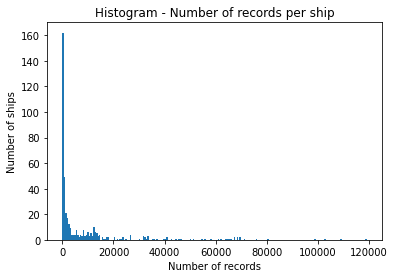

Total Duration per id
count    4.300000e+02
mean     1.405570e+07
std      1.155168e+07
min      5.999000e+03
25%      2.084238e+06
50%      1.317850e+07
75%      2.550271e+07
max      3.153453e+07
Name: t_diff, dtype: float64
Split trajectories ....
..............
 After "split trajectories if dt > VAL_GAP_PERIOD" 1800 Number of points : 4096936   &   Number of mmsi: 430   &   Number of id: 122902
SPLIT: After dropping ids with less than  10 Number of points : 3766811   &   Number of mmsi: 420   &   Number of id: 53694 
..............
36.00301146507263
..............
 After "split trajectories if traj_duration > VAL_MAX_TRAJ_DURATION" 86400 Number of points : 3766799   &   Number of mmsi: 420   &   Number of id: 53715
SPLIT: After dropping ids with less than  10 Number of points : 3766799   &   Number of mmsi: 420   &   Number of id: 53715 
..............
39.85684323310852
..............
 After "split trajectories if traj_num_points > VAL_MAX_TRAJ_POINTS" 1000 Number of points : 37667

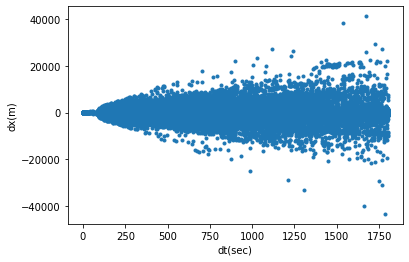

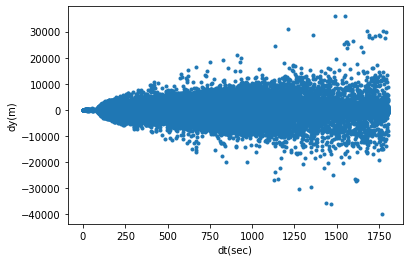

Shuffle id per dataset ....
Shuffle id:  68.88502073287964
Convert series to supervised problem ....
              mmsi  dataset_tr1_val2_test3_augm_0  \
0        237018400                              1   
1        237018400                              1   
2        237018400                              1   
3        237018400                              1   
4        237018400                              1   
...            ...                            ...   
3713079  240080500                              3   
3713080  240080500                              3   
3713081  240080500                              3   
3713082  240080500                              3   
3713083  240080500                              3   

         dataset_tr1_val2_test3_augm_0_norm     id   WGS84lon   WGS84lat  \
0                                         1      1  23.530130  39.166431   
1                                         1      1  23.538771  39.171829   
2                                 

KeyboardInterrupt: 

In [12]:
#######################################################################################################################

def main_function(RD, CSV_FILE_FOR_READ, DF_COL, N_TIMESTEPS, TIMESTEPS_AS_FORECAST_SEQUENCE, VAL_DEL_N_MIN_TMSTPS, VAL_NO_SPEED_THRESHOLD, VAL_MAX_SPEED_THRESHOLD, VAL_GAP_PERIOD, VAL_SHUFFLE_RAND, VAL_SHUFFLE_RAND_INIT, VAL_DATA_SPLIT_TR, VAL_DATA_SPLIT_VA):

    print("Read & Clean data ....")
    start = time.time()
    df = clean_data(CSV_FILE_FOR_READ, VAL_DEL_N_MIN_TMSTPS, VAL_NO_SPEED_THRESHOLD, VAL_MAX_SPEED_THRESHOLD, VAL_GAP_PERIOD)  # Clean data & Split to trajectories
    print("Read & Clean data: ", time.time() - start)
    
    print("----- BASIC DATASET -----")
    print('Number of points: %d, Number of mmsi: %d' % (df.shape[0], df.mmsi.unique().shape[0]))

    statistics_per_ship2(df)

    print("Split trajectories ....")
    start = time.time()
    df = split_trajectories(df, VAL_DEL_N_MIN_TMSTPS, VAL_GAP_PERIOD, VAL_MAX_TRAJ_DURATION, VAL_MAX_TRAJ_POINTS)
    print("Split trajectories: ", time.time() - start)


    print("Shuffle id ....")
    start = time.time()
    if VAL_SHUFFLE_RAND_INIT == 'YES':
        df = fun_shuffle(df, VAL_SHUFFLE_RAND)
    else:
        df = df.sort_values(by=['t'], ascending=[True], ignore_index=True).copy()
        df_ = df.drop_duplicates(subset=['id'], keep='first').copy()
        df_['id_dt'] = df_.groupby(['id']).ngroup() + 1
        df_ = df_[['id_dt', 'id']].copy()
        df_.rename(columns={"id": "d_id"}, inplace=True)
        df = pandas.merge(df_, df, left_on='d_id', right_on='id')
        df.drop(columns=['d_id', 'id'], inplace=True)
        df.rename(columns={"id_dt": "id"}, inplace=True)
        df.sort_values(by=['id', 't'], ascending=[True, True], inplace=True)
        df.reset_index(drop=True, inplace=True)
        del df_
    print("Shuffle id: ", time.time() - start)

    print("Split id into train and test sets ....")
    start = time.time()
    df, ntr, nva = split_into_sets(df, VAL_DATA_SPLIT_TR, VAL_DATA_SPLIT_VA)
    print("Split id into train and test sets: ", time.time() - start)


    print("Final dataset ---------------------------------")
    print('Number of points: %d, Number of mmsi: %d, Number of trajectories: %d' % (
    df.shape[0], df.mmsi.unique().shape[0], df.id.unique().shape[0]))
    print(df)

    plt.plot(df.dt, df.dlon, '.'); plt.xlabel('dt(sec)'); plt.ylabel('dx(m)'); plt.show()
    plt.plot(df.dt, df.dlat, '.'); plt.xlabel('dt(sec)'); plt.ylabel('dy(m)'); plt.show()


    print("Shuffle id per dataset ....");
    start = time.time()
    df = fun_shuffle_id(df, RD)
    print("Shuffle id: ", time.time() - start)


    print("Convert series to supervised problem ....")
    t = time.time()
    DF_COL = ['mmsi', 'dataset_tr1_val2_test3_augm_0', 'dataset_tr1_val2_test3_augm_0_norm', 'id',
              'WGS84lon', 'WGS84lat', 't', 'lon', 'lat', 'dist_m', 'dlon', 'dlat', 'dt', 'speed']

    df = df[DF_COL].copy().dropna().reset_index(drop=True)  # Keep specific columns & drop nan & reset index
    #df = trajectories_to_supervised(df, N_TIMESTEPS, TIMESTEPS_AS_FORECAST_SEQUENCE)
    df = trajectories_to_supervised_fast_df(df, N_TIMESTEPS, TIMESTEPS_AS_FORECAST_SEQUENCE)
    print(time.time() - t)
    
    #####################################lazaros############################################################################
  #  print("lazaros part")
  #  df['column_mmsi'] = numpy.where(df["mmsi(t-1)"] == df["mmsi(t)"], True, False)
  #  false_count = (~df.column_mmsi).sum()
  #  true_count = (df.column_mmsi).sum()
  #  print("num of different mmsi between mmsi(t) and mmsi(t-1)",(false_count))
  #  print("num of same mmsi between mmsi(t) and mmsi(t-1)",(true_count))
  ##  df['column_id'] = numpy.where(df["id(t-1)"] == df["id(t)"], True, False)
   # false_count = (~df.column_id).sum()
   # true_count = (df.column_id).sum()
   # print("num of different id between id(t) and id(t-1)",(false_count))
   # print("num of same id between id(t) and id(t-1)",(true_count))
   # print("end of lazaros part")
#########################################lazaros############################################################################

    
    #df.to_pickle('E:/Desktop/aegean/t20df_20210719.pkl')
    #df.to_csv('E:/Desktop/aegean/2batch_step_df_20210719.csv',index=True)
    #df.to_pikle('E:/Desktop/aegean/2_step_df_20210719.pkl')

    print("+++++ END +++++")
    




# #=====================================================================================================================
"""Run Process"""
# #====================================== SET PARAMETERS ===========================================================
RD = 1

CSV_FILE_FOR_READ = 'E:/Desktop/aegean/ais_kinematic_aegean_2018_type_passenger.csv'

VAL_DEL_N_MIN_TMSTPS = 10
VAL_MAX_TRAJ_DURATION = 86400#8640000000000000000000000000 #60(sec)*60(min)*24(hours)*1(days)
VAL_GAP_PERIOD = 1800 # mporw na to allaxw se 1 wra gia na paixw me to id
VAL_MAX_TRAJ_POINTS = 1000  # Split trajectories if num_points > VAL_MAX_TRAJ_POINTS
VAL_NO_SPEED_THRESHOLD = 0.5#0.05 # 0.05m/s equal to 0.1knots
VAL_MAX_SPEED_THRESHOLD = 25.7#13  # 50 knots = 92.6 km/h = 25.72 meters / second

VAL_DATA_SPLIT_TR = 0.55
VAL_DATA_SPLIT_VA = 0.15

VAL_SHUFFLE_RAND = 1
VAL_SHUFFLE_RAND_INIT = 'NO'  # 'YES', 'NO'

N_TIMESTEPS =  10 # Train On Multiple Lag Timesteps: n_timesteps>1
TIMESTEPS_AS_FORECAST_SEQUENCE = 10

# DF_COL = ['mmsi', 'id', 'WGS84lon', 'WGS84lat', 't', 'lon', 'lat', 'dist_m', 'dlat', 'dlon', 'dt', 'speed']
# DF_COL = ['shiptype', 'mmsi', 'dataset_tr1_val2_test3_augm_0', 'dataset_tr1_val2_test3_augm_0_norm', 'id', 'WGS84lon', 'WGS84lat', 't', 'lon', 'lat', 'dist_m', 'dlon', 'dlat', 'dt', 'speed']
# DF_COL = ['originPort_lon', 'originPort_lat', 'destinationPort_lon', 'destinationPort_lat', 'mmsi', 'dataset_tr1_val2_test3_augm_0', 'dataset_tr1_val2_test3_augm_0_norm', 'id', 'WGS84lon', 'WGS84lat', 't', 'lon', 'lat', 'dist_m', 'dlon', 'dlat', 'dt', 'speed']
DF_COL = ['mmsi', 'dataset_tr1_val2_test3_augm_0', 'dataset_tr1_val2_test3_augm_0_norm', 'id', 'WGS84lon', 'WGS84lat', 't', 'lon', 'lat', 'dist_m', 'dlon', 'dlat', 'dt', 'speed']

# #---------------------------------------------------------------------------------------------------------------------


# #=====================================================================================================================
"""--- MAKE REPRODUCIBLE RESULTS ---"""
os.environ['PYTHONHASHSEED'] = str(RD)  # Set `PYTHONHASHSEED` environment variable at a fixed value
random.seed(RD)  # Set `python` built-in pseudo-random generator at a fixed value
numpy.random.seed(RD)  # Set `numpy` pseudo-random generator at a fixed value




# #=================================================================================================================
main_function(RD, CSV_FILE_FOR_READ, DF_COL, N_TIMESTEPS, TIMESTEPS_AS_FORECAST_SEQUENCE, VAL_DEL_N_MIN_TMSTPS, VAL_NO_SPEED_THRESHOLD, VAL_MAX_SPEED_THRESHOLD, VAL_GAP_PERIOD, VAL_SHUFFLE_RAND, VAL_SHUFFLE_RAND_INIT, VAL_DATA_SPLIT_TR, VAL_DATA_SPLIT_VA)
# #=================================================================================================================


print('end')


In [ ]:
df0

In [ ]:
df = pandas.read_csv(CSV_FILE_FOR_READ, delimiter=';', header=0, index_col=None)
print(df)